# BGPDistinct
##### Analyzing BGP messages to classify them as either distinct or duplicated/propagated
*Author: Andy Dolan*

## *Abstract*
This report introduces methodologies to analyze Border Gateway Protocol (BGP) announcement messages with machine learning techniques, with the aim of classifying messages according to whether they belong to a distinct event or are mere propagations of other BGP messages. Neural networks are employed to accomplish this, and classification results are satisfactory when trained on a data set of nearly 11,000 captured BGP announcements.

## Introduction
Border Gateway Protocol (BGP) has been a fundamental component of the Internet for nearly 30 years [1]. The protocol provides automatic worldwide routing between autonomous systems (ASes), allowing network consumers to send packets to a destination by providing nothing more than the destination address. BGP relies on messages broadcast by BGP speakers within ASes that propagate information about how to reach different blocks of addresses in both the IPv4 and IPv6 address spaces. These messages, hereafter referred to as BGP updates, are sent by individual ASes constantly and automatically, so that routing can adapt during outages or congestion. In other words, the interconnected network of ASes is able to adapt to global network conditions, finding shortest paths along which to route consumer packets. As a result, a massive volume of messages are broadcast constantly among ASes, and are rarely seen by network consumers.

In this sense, BGP provides an abstraction that has allowed the Internet to flourish in terms of simplicity; that is, sending a packet anywhere in the world is as simple as knowing the address that it should be sent to. With such a global system that is largely running autonomously at scale, interesting characteristics can be observed when updates are captured, one of which is the number of messages broadcast during a period of time. Listening for the raw number of messages heard by one or more ASes is naïve, in the sense that many messages are only propagations of some original update. Conversely, only a small number of updates are distinct within a time period.

A distinct BGP update is defined here as an update $U$ that has a distinct composite key $C$, consisting of a prefix, prefix mask (e.g., “/24”), and destination AS number associated with it, such that no other update $U’$ that precedes $U$ within the specified time period has the same composite key. The timestamp of the updates comes into play as well, though only for time periods of an appropriate duration.

This report introduces methods with which BGP updates may be classified as distinct or merely propagated for a given time period, using neural networks. The potential benefits to a faithful classification of such messages include a simplified view of which autonomous systems are broadcasting more messages, differentiating between periods of high update creation vs. periods of high update propagation (e.g., “flapping”), and even use in anomaly detection. At the very least, the understanding of normal behaviors of BGP in today’s Internet may be better illustrated by this classification. The section that follows will provide background information on BGP, and subsequent sections will describe the methodology employed and provide examples.

## Background and Related Works
### Border Gateway Protocol
Border Gateway Protocol is used to communicate “network reachability information” among autonomous systems, where an autonomous system is a “set of routers under a single technical administration” [2]. More succinctly, BGP devices listen for update messages and use them to update their internal routing information bases. The information that these tables store is how to forward packets in order to reach a particular address space, so that incoming packets can be routed to the appropriate next hop on the way to their destination. BGP update messages have the capability of announcing and withdrawing advertised routes at the same time, or performing only one or the other [2]. This project only focused on messages that contained at least one advertised route, including messages that also contained withdrawn routes. In other words, messages that contained only withdrawn routes were ignored, and any withdrawals in remaining updates were not analyzed.

The BGP 4 standard [2] specifies that a BGP route announcement contains, among other fields, a prefix and a mask (originally referred to as a “length” in the standard), indicative of the address space to which the announcement pertains. To be clear, the mask represents the number of bits in the address range that remain static. For example, a mask of 8 for an IPv4 address (e.g., “255.0.0.0/8”) would indicate that only the first octet does not change, and therefore the corresponding address space would have 16,777,214 addresses available for use.

The standard also defines an AS_PATH attribute, which is used to track the path of ASes to reach the prefix being announced [2]. The AS_PATH may contain one or more AS_SEQUENCE or AS_SET fields, the former of which is ordered, while the latter is not [2]. This project also only considered BGP messages that maintained the order of their complete AS_PATH. The remainder of this document will refer to the destination AS of an announcement, which is defined as the last AS number found in the last AS_SEQUENCE in the AS_PATH.

As introduced above, this document will also refer to a composite key $C$ for each announcement, which contains the announced prefix, the mask, and the destination AS. These fields were used throughout the project to uniquely identify BGP messages. In practice, when a BGP speaker hears an advertisement, it may prepend its own AS number to the growing AS_PATH, update its own routing table, and propagate the message to its own neighbors [2]. This assumes that the advertisement conforms to any policies that the BGP device has defined, and that the advertised route is considered better than any existing entry in the BGP device’s routing table. Regardless, any propagated message $m$ should share the same composite key $C$ as any other propagated message $m’$, as well as the original message $o$.

### Related Works
Machine learning techniques have been applied to BGP update data in [3], [4], and [5]. However, these techniques were applied in the context of anomaly detection. In [3], Al-Rousan and Trajkovic performed a binary classification on BGP messages, to determine whether any arbitrary message was anomalous or not. Support vector machines and hidden Markov models (the latter is a variation of a neural network) were utilized in [3] on a set of particular features from BGP messages, including the raw number of messages during a time period, and the number of duplicate messages, defined in the paper as “BGP update packets that have identical NLRI prefixes and AS-PATH attributes.” Al-Rousan and Trajkovik [3] found that these “volume features” could be used to accurately classify BGP messages as anomalous. In [4], Ding, Batta, and Trajkovik expand on the previous work in [3] by comparing long short-term memory recurrent neural networks to support vector machines. In both [3] and [4], support vector machines provided better classification accuracy than did the variations on neural networks, though both performed reasonably well. Allahdadi, Mortla, and Prior [5] also utilized support vector machines to perform classification of anomalous BGP messages with particularly relevant features that were extracted.

All three works trained classifiers on sets of anomalous data with supervised learning. All three also included the concept of duplicated messages, based on prefix and path attributes, as input features to their machine learning techniques. These works provide somewhat of a complement to the problem addressed in this project. They investigated using volumetric features to classify BGP messages found during anomalous events, including attacks, while this project focuses on the calculation of a particular volumetric measure of BGP announcements over time, that being whether a BGP announcement is distinct or propagated, to potentially be used in an application such as anomaly detection.

## A Note on Notebook Structure
The core elements of `BGPDistinct` were created as three main Python packages: `preprocessing`, `labeling`, and `learning`. This notebook itself does not contain the code definitions of these packages, but instead imports them from external sources. By default, it is assumed that this notebook is contained in its original directory structure of the BGPDistinct project. If you do not have these code definitions, they can be retrieved from the [repository](https://github.com/adolan5/BGPDistinct) on GitHub. This notebook will hereafter utilize these packages.

In [27]:
import sys
import os
# This assumes that the BGPDistinct codebase is located in ../src
sys.path.append('../src/')

import json
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from preprocessing import *
from labeling import Labeler
from learning import *
from torch import cuda, nn, optim, tensor
%matplotlib inline

## Methodologies
### Data Set and Preprocessing
All data for this project was gathered from the [BGPMon](https://www.bgpmon.io/) project’s [public API](http://bgpmon.io/archive/help) [6]. BGPMon is a BGP monitoring system that aggregates and archives captured BGP messages in XML format [6]. The data is available through the public API in a variety of formats and for a wide range of time. Data used for this project was downloaded in JSON format. The data itself contained BGP update messages with the relevant fields described in the introduction, as well as several others described in [2]. Most implementation steps were performed on a particular data set that spanned one minute, from 20:22 to 20:23 UTC on November 15th, 2018. This data can be retrieved with the `get_data` bash script found in the data directory (assumes `cURL` or `Wget`).

In [2]:
# Get data if it is not already present
!bash ../data/get_data.sh

Using cURL
File ../data/raw_one_min_nov15.json already exists. Aborting.


In order to process the data, a `preprocessing` package was created and the `DataFormatter` class was implemented and used to include only well-formed updates that had necessary characteristics for analysis.

In [3]:
df = DataFormatter('../data/raw_one_min_nov15.json')

In [4]:
print('Total number of messages from file:', df.get_num_messages())
print('Number of malformed messages from file:', df.num_malformed)
print('Number of withdraw-only messages from file:', df.num_withdraws)
print('Number of messages containing an AS_SET:', df.num_as_set)
print('Number of announcements from file:', len(df.formatted_data))
print('\nExample of a formatted BGP announcement update:')
print(df.formatted_data[0])

Total number of messages from file: 7235
Number of malformed messages from file: 19
Number of withdraw-only messages from file: 529
Number of messages containing an AS_SET: 0
Number of announcements from file: 6706

Example of a formatted BGP announcement update:
{'mrt_header': {'type': 16, 'subtype': 4, 'len': 170, 'timestamp': 1542313320}, 'bgp4mp_header': {'peer_as': 63956, 'local_as': 6447, 'address_family': 2, 'peer_ip': '2402:1b80::1', 'local_ip': '2001:468:d01:33::80df:330f'}, 'bgp_header': {'marker': '/////////////////////w==', 'length': 126, 'type': 2}, 'bgp_update': {'advertized_routes': [{'prefix': '2620:0:2f0::', 'mask': 48}], 'attrs': {'optional_bit': True, 'extended_bit': True, 'as_path': [{'as_seq': [63956, 4637, 174, 32629]}], 'communities': {'communities': [{'community': 'Eh19JRIdfjoSHX74Eh3uGPnUdTD51HU1+dR5GPnUeUA='}, {'extended_community': 'AAL51AAAAZU='}]}, 'types': [1, 2, 8, 16, 14, 3], 'next_hop': '2402:1b80::1'}}}


Of 7,235 of the messages contained in this 60 second time frame, 6,706 were BGP announcements. The remaining messages contained only updates of route withdrawals or were malformed.

Once the data had been properly formatted, filtered by desirable characteristics, and sorted by its timestamp, key features were extracted by another class, DataExtr. This class was responsible for capturing the fields of primary interest in each BGP announcement, including the timestamp, the prefix, the mask, the destination AS number, and the full path of the announcement. The lattermost field was included only for readability and use during manual labeling. The other fields were chosen for their utility in identifying any announcement as potentially part of the same distinct event. The timestamp is included separate from the composite key due to the fact that it may independently determine whether or not an announcement is a propagation of some previous message vs. a new distinct message. To illustrate this concept, consider the example of an announcement $A$ that shares the same composite key with another announcement $A’$ that was broadcast 24 hours earlier. Given the nature of BGP and the constant stream of messages that are propagated relatively quickly throughout the network, it is unlikely that $A$ is a propagation of $A’$, but that $A$ is rather a propagation of a more recent announcement or is itself a new announcement altogether. Even so, this project did not take the temporal difference of announcements into account, but still used the timestamp as an input to the neural network.

It is also important to note that [2] allows for aggregation of advertised prefixes and masks in a single BGP update, so long as all routes being advertised share the same path (and therefore destination AS number). In order to fully investigate distinct updates, any message that contained $n$ advertised prefixes and masks, where $n > 1$, was considered to be n separate logical announcements, each of which advertised only one prefix and mask, and shared the same AS_PATH and timestamp. For the Nov. 15 data set, this increased the number of announcements to 10,959. This also clearly indicates the fact that announcement aggregation does take place quite frequently in BGP. During runtime, the extracted data was formatted as a Python dictionary, containing a timestamp, a composite key consisting of a prefix, a mask, and a destination AS number, and the full path of the BGP announcement, which had been reconstructed in the case that it was made up of several individual AS_SEQUENCEs. An example of the extracted data is seen in the cell below.

In [5]:
de = DataExtr(df.formatted_data)

In [6]:
print('Example of an extracted message:')
print(json.dumps(de.extracted_data[0], indent=2))
print('\nNumber of extracted single-prefix announcements:', len(de.extracted_data))

Example of an extracted message:
{
  "time": 1542313320,
  "composite": {
    "prefix": "2620:0:2f0::",
    "mask": 48,
    "dest": 32629
  },
  "full_path": [
    63956,
    4637,
    174,
    32629
  ]
}

Number of extracted single-prefix announcements: 10959


## Initial Data Experiments
Once preprocessing had been completed, one of the preliminary investigations into the amount of announcements that are only propagated vs. distinct came in the form of simple experiments performed on the extracted data. These experiments were performed with a larger data set that spanned an hour’s worth of time, containing nearly 255,000 update messages with about 5,000 unique destination AS numbers.

In [7]:
# The previous bash script can be used to download the large data set (warning: 160 MB in size!)
!bash ../data/get_data.sh large

Using cURL
File ../data/raw_large_set_nov1.json already exists. Aborting.


In [8]:
# Perform preprocessing on larger set, timing it
start = time.time()
large_df = DataFormatter('../data/raw_large_set_nov1.json')
format_time = time.time()
large_de = DataExtr(large_df.formatted_data)
end = time.time()

print('Formatting took {} seconds'.format(format_time - start))
print('Extraction took {} seconds'.format(end - format_time))

Formatting took 29.88955044746399 seconds
Extraction took 2.1871607303619385 seconds


In [9]:
print('Total number of messages:', large_df.get_num_messages())
print('Number of malformed messages:', large_df.num_malformed)
print('Number of messages containing an AS_SET:', large_df.num_as_set)
print('Number of valid announcements:', len(large_de.extracted_data))
print('')

# Calculate the number of unique composite keys
unique_composites = set([tuple(s.get('composite').values()) for s in large_de.extracted_data])
print('Number of unique composite keys:', len(unique_composites))
print('{:.2%} of all messages had a distinct composite key.'.format(len(unique_composites) / len(large_de.extracted_data)))

Total number of messages: 268101
Number of malformed messages: 146
Number of messages containing an AS_SET: 298
Number of valid announcements: 692127

Number of unique composite keys: 31428
4.54% of all messages had a distinct composite key.


After preprocessing, the raw number of logical announcements rose to nearly 700,000, even though there were under 35,000 unique prefix, mask, and destination AS combinations, suggesting a high amount of duplication. That suspicion was confirmed when the number of unique composite keys was graphed against the total number of announcements for each minute of the hour, as displayed below. Overall, the number of announcements with unique composite keys made up under 5% of the total number of announcements.

In [10]:
# Set global font size for matplotlib
plt.rcParams.update({'font.size': 12})

# Get the number of unique composite keys for each minute of the full hour
# comps_per_min = len(set([tuple(s.get('composite').values()) for s in subset]
def show_duplication(data, interval=10, use_xticks=True):
    """Produce a graph that illustrates how much duplication takes place during
    every interval.
    Args:
    data (list): The data to analyze.
    interval (int): The number of seconds per bucket for which to
        collect messages.
    use_xticks (bool): Whether or not to label each interval of
        the resulting graph.
    """
    comps_per_int = []
    messages_per_int = []
    start_time = data[0].get('time')
    end_time = data[-1].get('time')
    for i in range((end_time -start_time) // interval):
        bucket_start = start_time + (interval * i)
        bucket_end = bucket_start + interval
        all_comps = [tuple(s.get('composite').values())
                            for s in data if bucket_start <= s.get('time') < bucket_end]
        comps_per_int.append(len(set(all_comps)))
        messages_per_int.append(len(all_comps))

    # Create and label the chart
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 8)
    plt.xticks(rotation=90)
    plt.tick_params(bottom=use_xticks, labelbottom=use_xticks)
    plt.title('Duplication of BGP Announcements over {} seconds, {} Second Intervals'.format((end_time - start_time), interval))
    plt.xlabel('Interval ({} seconds each)'.format(interval))
    plt.ylabel('Number of messages')
    
    # Create bars and legend
    interval_labels = [str(x) for x in range(len(messages_per_int))]
    all_bar = ax.bar(interval_labels, messages_per_int)
    unique_bar = ax.bar(interval_labels, comps_per_int)
    plt.legend([all_bar, unique_bar], ['All messages', 'Unique composite keys'])
    plt.show()

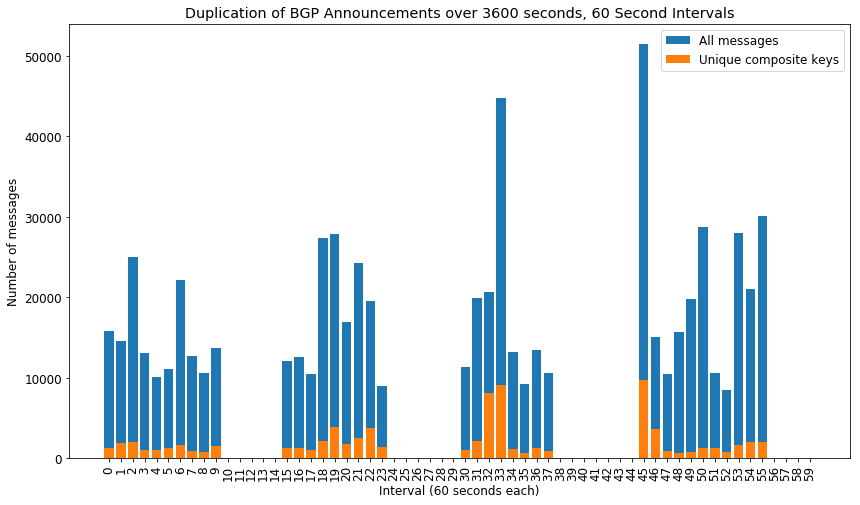

In [11]:
show_duplication(large_de.extracted_data, 60)

Clearly, there are many BGP announcements that are propagated. It may be the case that some of these messages are actually results of reannouncements (i.e., announcements that were made at a later time). We can see that this property holds at a more fine grained time interval such as every 10 seconds.

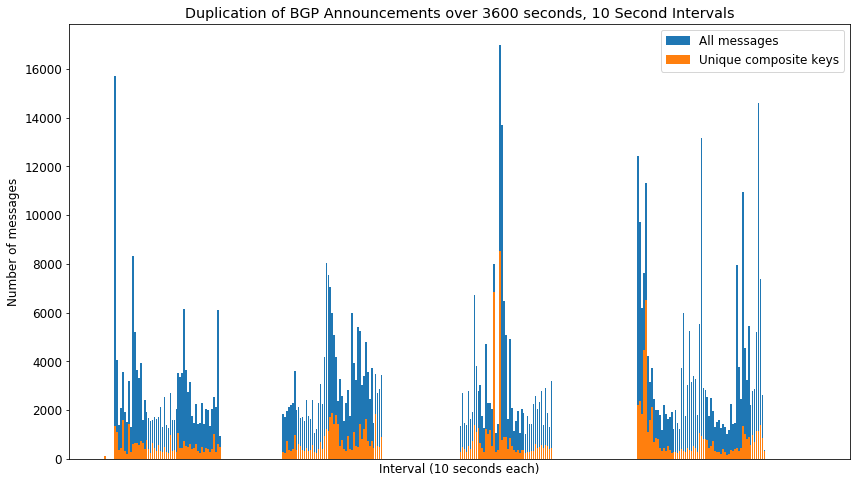

In [12]:
show_duplication(large_de.extracted_data, 10, use_xticks=False)

We can also see the same behavior in the smaller, minute-long data set. A similar ratio of distinct composite keys to total messages was calculated at 7%, with 774 unique composite keys to in the 10,959 total announcements.

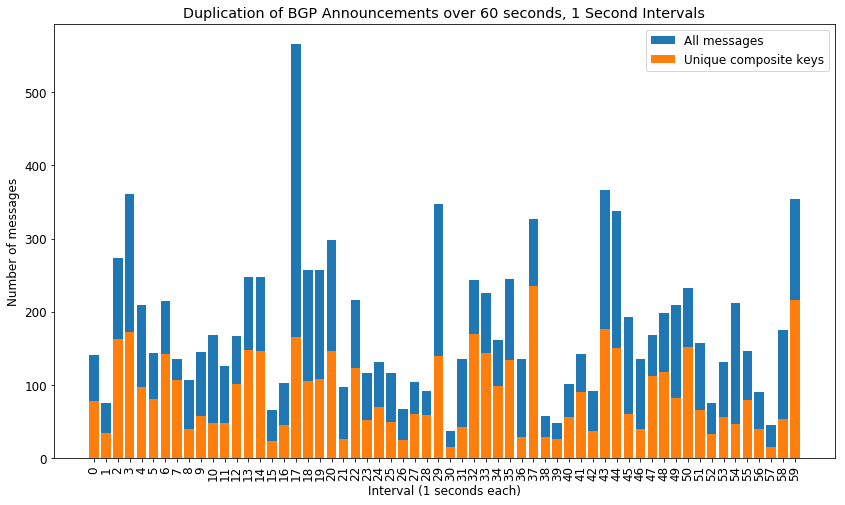

In [13]:
show_duplication(de.extracted_data, 1)

In [14]:
unique_composites = set([tuple(s.get('composite').values()) for s in de.extracted_data])
print('{:.2%} of all messages had a distinct composite key.'.format(len(unique_composites) / len(de.extracted_data)))

7.06% of all messages had a distinct composite key.


## Data Rescaling and Standardization
The key features from any one BGP announcement included the UTC timestamp, the prefix, mask, and destination AS number. The only field that was not already a number was the prefix, which could easily be converted (IPv6 is hex-based and each octet of IPv4 represents 8 bits). However, two problems were present regarding using the features as inputs to a neural network. First, an IPv6 address is 128 bits, and will not fit in a 64 bit unsigned integer. Secondly, and more generally, all of the values differed greatly from each other in terms of range, and so would not provide effective learning when input to a neural network. In other words, some values varied so greatly that they could be misinterpreted by the network as more significant determinants, when they were more arbitrary in reality. The solution to both problems was feature rescaling by means of standardization, a common technique in machine learning. This technique was also employed in [5]. This solution also applied to the prefix problem, but an extra step was taken to ensure that the potentially large values of prefixes were truly downscaled; for a converted prefix $p$ the natural log $ln(p)$ was first taken. The second step was the standardization, which applied the equation below to each value in the extracted data, such that any set of values for any feature had a mean of 0 and a standard deviation of one.

$$
\frac{x - \bar{x}}{\sigma}
$$

## Modeling a Classificaiton Problem and Labeling Data
The primary objective of this project was a simple binary classification of BGP updates. The two classes are referred to here as “distinct” and “duplicated” (or “propagated”). Previous sections have described what makes a BGP update distinct from another; the caveat that became apparent for this data is that the order of the updates must be preserved (and is indeed significant), and that messages are classified as distinct or duplicated based only on what messages precede them. This fact complicated the labeling process, as partitioning the data into different sets could foundationally change which class any one message belonged to. In most classification problems, there is a static mapping from an input to its expected class (output) that does not change if the data is shuffled, partitioned, or only a subset is used. BGP data does not share this quality.

Consequently, labeling (or re-labeling) every input in a partition was required whenever partitioning took place. Since training a neural network involves several instances of partitioning data, manual labeling of thousands of data points over and over was considered infeasible. Instead, a naïve labeling approach was implemented in the `labeling` package, wherein announcements were classified automatically based on whether or not their composite keys had already appeared in the same set or not. Therefore, the temporal part of the data was not leveraged in labeling decisions. Considering that the duration of the time frame analyzed was only 60 seconds, it is likely that any resulting difference in target classifications would be negligible. The labeling routine and a stronger focus on the temporal differences between announcements remains an interest for future work. Use of the naive method is seen below.

In [15]:
# The Labeler class performs labeling on data in place
Labeler(de.extracted_data)
print([(s.get('composite').get('prefix'), s.get('distinct')) for s in de.extracted_data[:10]])

[('2620:0:2f0::', 1), ('2a0b:d080::', 1), ('94.185.102.0', 1), ('94.185.101.0', 1), ('90.158.112.0', 1), ('90.158.121.0', 1), ('195.36.0.0', 1), ('208.110.96.0', 1), ('2a0b:d080::', 0), ('177.190.208.0', 1)]


## Neural Network Structure and Evaluation
The [PyTorch](https://pytorch.org/) library was utilized for creating neural networks and performing data manipulations.

### First Network Structure
The first neural network structure for this classification problem was simplistic and modeled a regression problem, where the output was a single value. This structure, depicted below, contained an input layer, two hidden layers of a variable number of neurons, and a final output layer. All layers applied linear functions and a Rectified Linear Unit (ReLU) activation function, both defined in the PyTorch library. The last layer of the original structure differed, having no activation function between the linear layer and the final output. The loss (i.e., “error”) calculation between predicted outputs from the network and the expected target values was produced by a regular mean squared error, and stochastic gradient descent was used to minimize those error values, with a learning rate of 0.1.

![image.png](./images/FirstNetwork.png)

#### First Network: Evaluation
For convenience, a function to display resulting classifications is defined here:

In [16]:
# Function to display the resulting classificaiton of a network
def display_results(actual, predicted):
    """Display the results of a network's predicted classifications.
    Args:
    actual (list): The list of actual classifications that were expected.
    predicted (list): The list of predicted classificaitons output by the network.
    """
    alpha = 0.1
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    ax.plot(actual, 'o', alpha=alpha, label='actual')
    ax.plot(predicted, 'o', alpha=alpha, label='predicted')
    plt.legend()
    plt.ylabel('Class (1 = distinct, 0 = duplicate)')
    plt.xlabel('Data point index, ordered by time')
    plt.title('Classification for Training Set')
    plt.show()

Note that, if available, the network structures will utilize CUDA:

In [19]:
if cuda.is_available():
    !nvidia-smi
else:
    print('Computation will be performed on the CPU')

Sun Dec  9 20:10:45 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 960M    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |     11MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

While it did not provide very definitive classifications, this network did provide the fundamental insight that classification of BGP announcements based on the criteria described here would be possible. Alterations to the parameters of the first network structure did not prove to greatly improve results, and so it serves as an introductory example.

In [20]:
# Creating a network of the first structure
first_net = FirstNetworkStruct(num_neurons=10)
net_manager = NetworkBGP(de.extracted_data, first_net)
print(net_manager.net)

FirstNetworkStruct(
  (inputs): Linear(in_features=4, out_features=10, bias=True)
  (act): ReLU()
  (hidden): Sequential(
    (h1): Linear(in_features=10, out_features=10, bias=True)
    (a1): ReLU()
    (h2): Linear(in_features=10, out_features=10, bias=True)
    (a2): ReLU()
  )
  (output): Linear(in_features=10, out_features=1, bias=True)
)


We can now see an example of the rescaled training data as well. Note that each element contains four values that are mapped to message timestamp, prefix, mask, and destination AS.

In [21]:
net_manager.Xtrain[0:3]

tensor([[-1.6624,  2.6087,  1.3852, -0.4335],
        [-1.6624,  2.6131,  0.3206,  1.4538],
        [-1.6624, -0.3921, -0.2117,  1.3695]],
       device='cuda:0', dtype=torch.float64)

In [22]:
# Setting the optimizer and loss function parameters
optimizer = optim.SGD(net_manager.net.parameters(), lr=0.1)
loss_func = nn.MSELoss()

# Training the network for 6,000 iterations
e = net_manager.train_network(optimizer, loss_func, 6000)

Training took 15.037384748458862 seconds


The cell below displays the output of the first network on entries in the training set after training. The network provided a clear bias towards distinct messages appearing at the beginning of the time frame, which intuitively makes sense, as any message with index m in the set of n messages may be a duplicate of as many as m – 1 other messages, where m >= 1. Hence, the first message is always distinct, the second has a 50% chance of being distinct, and so on.

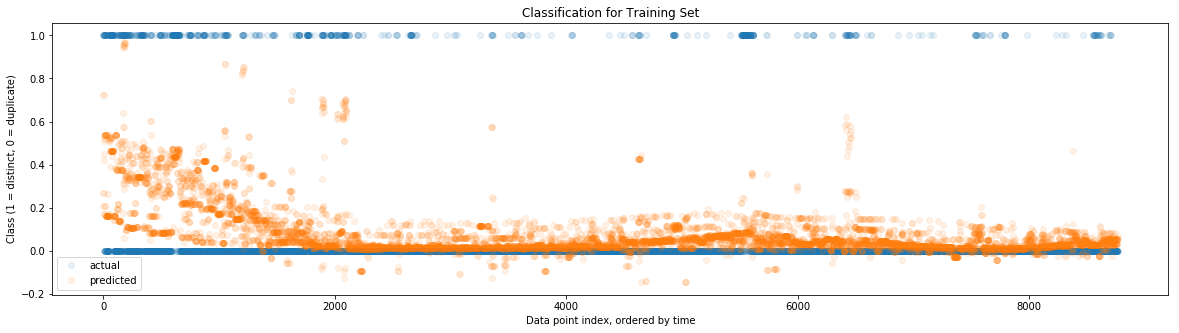

In [23]:
predicted = net_manager.net(net_manager.Xtrain).detach().cpu().numpy()
actual = net_manager.Ttrain.cpu().numpy()
display_results(actual, predicted)

An interesting finding for this network was how low the values of its outputs were, though this was likely due to the disparity between the two different classes of announcement (recall that distinct announcements only made up 7% of the analyzed data set). Therefore, the network was able to maintain its low error; it did not incorrectly classify many inputs simply because there were not many distinct announcements to incorrectly classify.

In [24]:
def plot_error(e):
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    ax.plot(e)
    ax.set_title('Average Error During Training')
    ax.set_xlabel('Training iteration')
    ax.set_ylabel('Average error')
    plt.show()

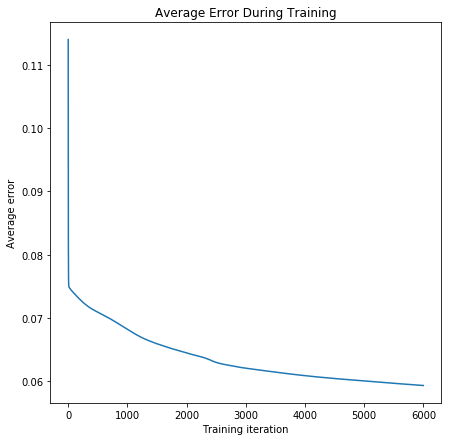

In [25]:
plot_error(e)

### Second Network Structure
The second implementation of the neural network, illustrated below, provided a more modular structure that could create an arbitrary number of hidden layers, each with the same definable number of neurons. These layers were the same combination of linear functions paired with ReLU activation functions. The output layer for the second structure differed from the first as well, with the addition of an activation function suitable for classification, the LogSoftmax function. A Softmax function produces, for an input vector of $n$ elements, an output vector of n elements that sum to 1 [7]. In terms of a classification problem, the resulting vector can be thought of as the probabilities that the input data point belongs to the class represented by the index of each entry. The LogSoftmax function applies a natural logarithm to these items, resulting in a vector of $n$ elements that range from negative infinity to zero [7]. As a result, the Negative Log Likelihood Loss (NLLLoss) function can then be used to compute the error of the classification. This function does so by computing the expected class from the output of the network (which can be done by finding the argmax of the output), and aggregating the mean errors for each output vector [7]. Additionally, this function allows a set of weights to be applied at the aggregation step, such that different classifications can produce more significant errors. In the case of this network, duplicate announcements were initially assigned a weight of 0.1, while distinct announcements were assigned a weight of 1. For optimization and minimization of the error values, the Adam algorithm was also utilized. Adam is a recently developed stochastic optimization algorithm that provides optimizations for high-dimension and large-sized data sets [8].

![image.png](./images/SecondNetwork.png)

The initial parameters of the second network structure included two hidden layers, each with 10 neurons. The learning rate of the Adam optimization function was initially 0.01, the weights assigned to the NLLLoss function were 0.1 for duplicate announcements and 1 for distinct, and the number of training iterations was typically in the range of 6,000 to 10,000.

In [34]:
# Creating a network of the second structure
net = SecondNetStruct(n_hidden=2, n_neurons=10)
net_manager = NetworkBGP(de.extracted_data, net)
print(net)

# Creating optimization and loss function for second network
optimizer = optim.Adam(net_manager.net.parameters(), lr=0.01)
loss_func = nn.NLLLoss(weight=tensor([0.1, 1], dtype=torch.double).to(net_manager.device))

# Train for 6,000 iterations
e = net_manager.train_network(optimizer, loss_func, 6000)

SecondNetStruct(
  (h0): Linear(in_features=4, out_features=10, bias=True)
  (a0): ReLU()
  (hidden_sequence): Sequential(
    (h1): Linear(in_features=10, out_features=10, bias=True)
    (a1): ReLU()
    (h2): Linear(in_features=10, out_features=10, bias=True)
    (a2): ReLU()
  )
  (raw_out): Linear(in_features=10, out_features=2, bias=True)
  (out_act): LogSoftmax()
)
Training took 31.86583423614502 seconds


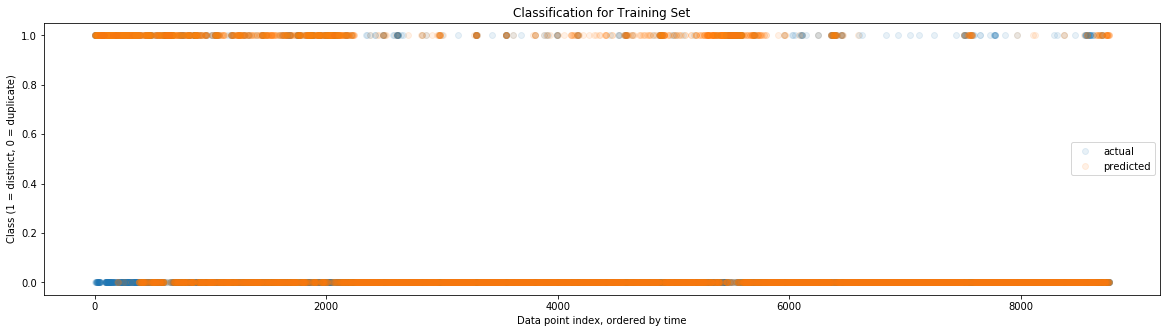

In [35]:
predicted = SecondNetStruct.get_predicted_classes(net_manager.net(net_manager.Xtrain))
actual = net_manager.Ttrain.cpu().numpy()
display_results(actual, predicted)

The initial results from the second network structure with these parameters were promising, usually achieving ~85% accurate classification for duplicate announcements, ~80% accurate classification for distinct announcements, and ~85% accurate overall classification for the training set. Use of the network on the testing set produced only 50% accuracy in classification for distinct announcements, lowering the overall classification accuracy to ~80%.

In [36]:
def display_correct(ratios):
    """Display charts that show the ratios of correct classification."""
    labels = ['Correct', 'Incorrect']
    fig, ax = plt.subplots(1, 3)
    for i, a in enumerate(ax):
        a.pie([ratios[i], 1 - ratios[i]], labels=labels, autopct='%.2f%%')

    ax[0].set_title('Overall Classification')
    ax[1].set_title('Classification of Duplicate')
    ax[2].set_title('Classification of Distinct')
    fig.set_size_inches(10, 10)

Displaying classification accuracies for the training set:

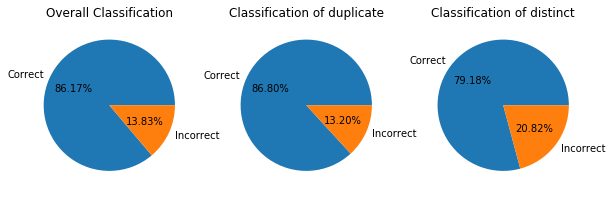

In [37]:
ratios = net_manager.get_correct(predicted, actual.flatten())
display_correct(ratios)

And now for the test set:

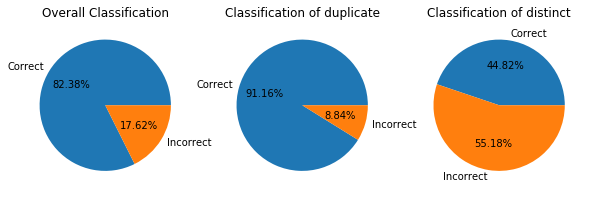

In [38]:
predicted = SecondNetStruct.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.cpu().numpy()
ratios = net_manager.get_correct(predicted, actual.flatten())
display_correct(ratios)

The first parameter that required tuning was the learning rate, which had initially produced a high variance during training, as seen below. Once lowered to 0.0005, the network produced a better error curve with much less variance, though classification accuracies still remained the same.

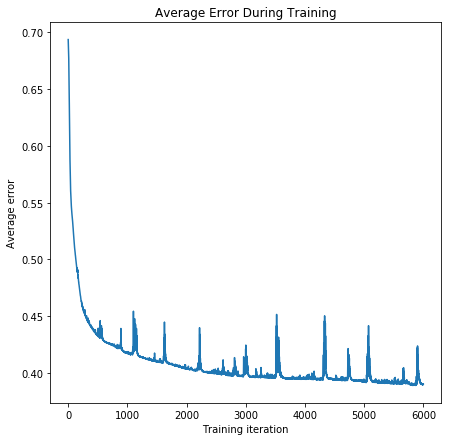

In [39]:
plot_error(e)

In [40]:
# Adjusting network parameters
net = SecondNetStruct(n_hidden=2, n_neurons=10)
net_manager = NetworkBGP(de.extracted_data, net)

optimizer = optim.Adam(net_manager.net.parameters(), lr=0.0005)
loss_func = nn.NLLLoss(weight=tensor([0.1, 1], dtype=torch.double).to(net_manager.device))

# Train for 6,000 iterations
e = net_manager.train_network(optimizer, loss_func, 6000)

Training took 31.888635873794556 seconds


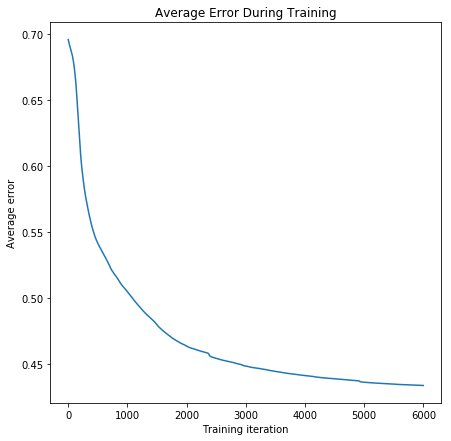

In [41]:
# Plot error again
plot_error(e)

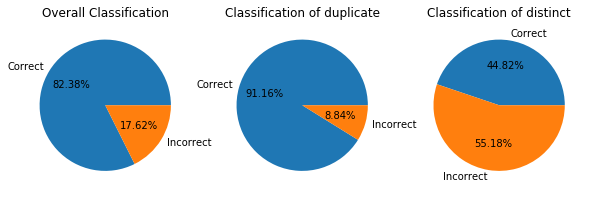

In [42]:
ratios = net_manager.get_correct(predicted, actual.flatten())
display_correct(ratios)

An increase in the number of hidden layers did not significantly improve the output accuracies; however, increasing the number of neurons in each layer did provide an improvement when run on the test set, though only for certain trials. This inconsistency indicated that such a change would not improve the network overall.

In [43]:
# A network with a higher number of neurons per layer
net = SecondNetStruct(n_hidden=2, n_neurons=50)
net_manager = NetworkBGP(de.extracted_data, net)

optimizer = optim.Adam(net.parameters(), lr=0.0005)
# Note that loss_func is still the same

e = net_manager.train_network(optimizer, loss_func, 6000)

Training took 100.97983717918396 seconds


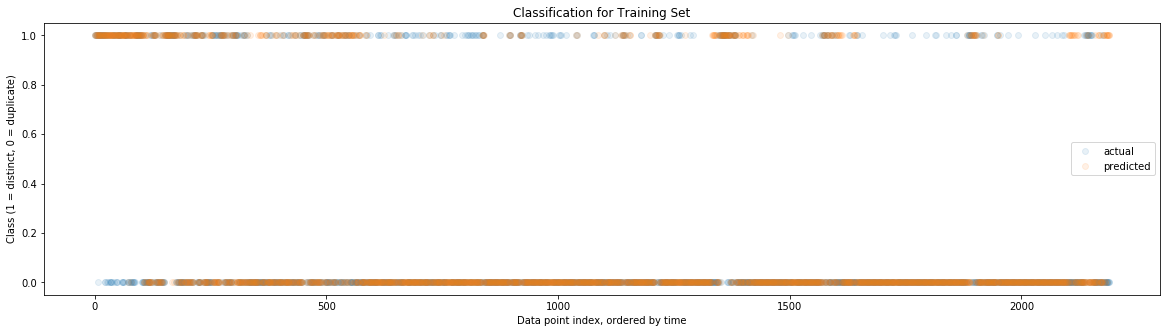

In [44]:
predicted = SecondNetStruct.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.cpu().numpy()
display_results(actual, predicted)

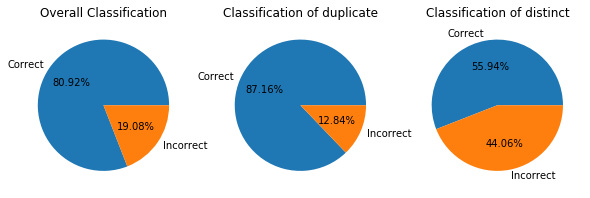

In [45]:
ratios = net_manager.get_correct(predicted, actual.flatten())
display_correct(ratios)

Raising the weight used in the loss function associated with duplicate announcements to reflect the true proportion of distinct announcements to duplicate announcements did not improve the network’s performance. Significantly lowering the same weight to 0.01 placed a disproportionate amount of significance on announcements classified as distinct, which greatly deteriorated the network’s performance as well.

Training took 31.88632869720459 seconds


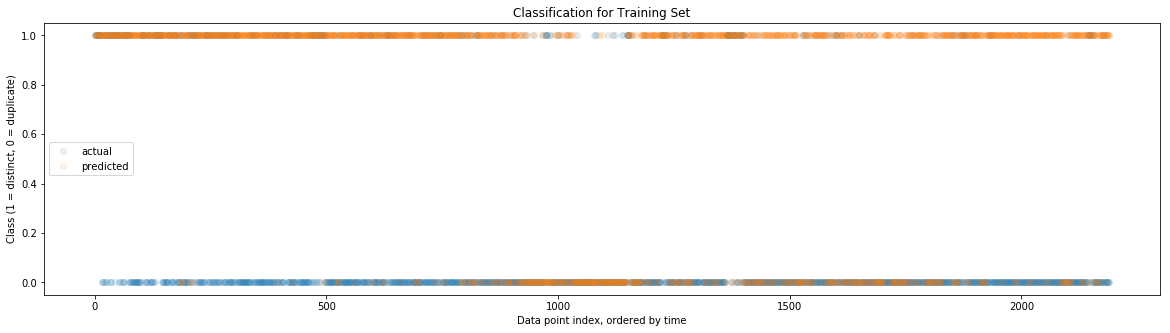

In [47]:
# A network with a significantly lowered weights associated with duplicate messages
net = SecondNetStruct(n_hidden=2, n_neurons=10)
net_manager = NetworkBGP(de.extracted_data, net)

optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_func = nn.NLLLoss(weight=tensor([0.01, 1], dtype=torch.double).to(net_manager.device))

e = net_manager.train_network(optimizer, loss_func, 6000)

predicted = SecondNetStruct.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.cpu().numpy()
display_results(actual, predicted)

Lowering the weight only slightly, to 0.08, produced a slight improvement in the resulting classification accuracy for distinct announcements in the testing set, raising it to approx. 55% while maintaining accuracy for duplicates and overall classifications.

Training took 31.914676666259766 seconds


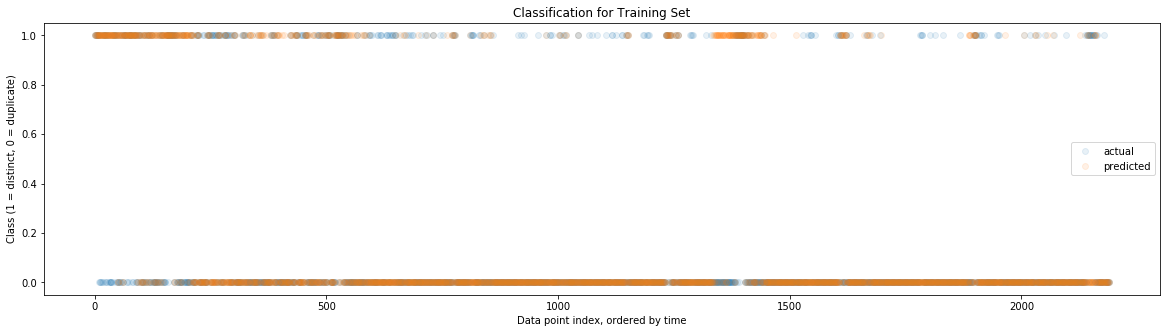

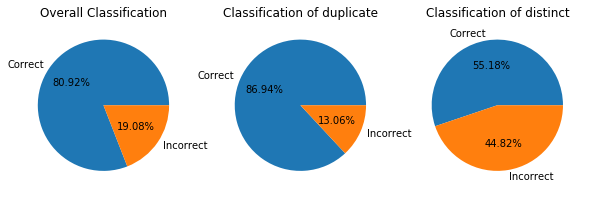

In [48]:
# The network with the best performance
net = SecondNetStruct(n_hidden=2, n_neurons=10)
net_manager = NetworkBGP(de.extracted_data, net)

optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_func = nn.NLLLoss(weight=tensor([0.08, 1], dtype=torch.double).to(net_manager.device))

e = net_manager.train_network(optimizer, loss_func, 6000)

predicted = SecondNetStruct.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.cpu().numpy()
display_results(actual, predicted)

ratios = net_manager.get_correct(predicted, actual.flatten())
display_correct(ratios)

It should be noted that some trials saw marked improvements in classification accuracies on all fronts, while others saw subpar results, likely due to the random nature of the partitioning routine. The final network structure that provided the best results included two hidden layers of ten neurons each, a learning rate of 0.0005, and weights of 0.08 and 1 associated to the duplicated and the distinct classes, respectively. Across 10 separate trials of 6,000 training iterations, the second network averaged 78% accuracy for overall classification, 83% accuracy for classification of duplicate announcements, and betweeen 55% and 59% accuracy for classification of distinct announcements, when the network was used on the corresponding testing set.

In [49]:
all_overall = []
all_duplicate = []
all_distinct = []
for i in range(1, 11):
    print('Iteration', i)
    # Create and train a network
    net = SecondNetStruct(n_hidden=2, n_neurons=10)
    net_manager = NetworkBGP(de.extracted_data, net)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
    loss_func = nn.NLLLoss(weight=torch.tensor([0.08, 1], dtype=torch.double).to(net_manager.device))
    net_manager.train_network(optimizer, loss_func, 6000)
    predicted = SecondNetStruct.get_predicted_classes(net_manager.net(net_manager.Xtest))
    actual = net_manager.Ttest.cpu().numpy()
    ratios = net_manager.get_correct(predicted, actual.flatten())
    
    # Update ratio collections
    all_overall.append(ratios[0])
    all_duplicate.append(ratios[1])
    all_distinct.append(ratios[2])
    

Iteration 1
Training took 31.884963035583496 seconds
Iteration 2
Training took 31.896028995513916 seconds
Iteration 3
Training took 31.90907120704651 seconds
Iteration 4
Training took 31.892945528030396 seconds
Iteration 5
Training took 31.90139389038086 seconds
Iteration 6
Training took 31.902392148971558 seconds
Iteration 7
Training took 31.898881435394287 seconds
Iteration 8
Training took 31.896203756332397 seconds
Iteration 9
Training took 31.906975984573364 seconds
Iteration 10
Training took 31.90396523475647 seconds


In [50]:
# Print out average accuracy for each classification
print('Average overall classification accuracy: {:.2%}'.format(np.mean(all_overall)))
print('Average duplicate classification accuracy: {:.2%}'.format(np.mean(all_duplicate)))
print('Average distinct classification accuracy: {:.2%}'.format(np.mean(all_distinct)))

Average overall classification accuracy: 79.40%
Average duplicate classification accuracy: 84.87%
Average distinct classification accuracy: 56.32%


## Discussion and Future Work
The second network structure took the main focus of this project, providing promising results in accurately classifying BGP announcements as distinct or merely propagated. The minor alterations to the learning rate and weight associated with duplicate announcements provided a significant increase in performance of the network.

The relatively simple structure of the final network also suggests that more refined networks could provide better classification results for sets of BGP data with arbitrary durations. The fact that temporal difference is not truly leveraged in this classification problem also provides a basis for future work. It seems that much of the wide variation in the results of training may be attributed to the partitioning and labeling problem described before. When BGP announcements are partitioned, they must be relabeled, as an announcement is only considered to be distinct within the context of all the messages in the set that precede it. This may result in test sets that vary greatly when compared to the training sets from which they were originally derived. The labeling routine itself is also naïve, and so provides an opportunity for future work that would ideally result in better and a larger number of labeled datasets to be used for this application.

## Conclusion
This project introduced a methodology of extracting key information from raw BGP announcement messages and determining whether any BGP announcement belongs to a distinct event or is merely a propagation, using neural networks. The resulting networks maintain a simple structure that leaves much room for refinement, but also provide acceptable results for classification. Overall, the results of this project confirm that it is possible to break BGP messages containing announcements down to their key attributes and, using machine learning methodologies, determine whether or not they belong to a distinct event.
## *Acknowledgements*
I would like to thank Dr. Anderson and  Dr.Gersch for allowing me to take on this project to meet requirements for both CS 440 and CS 557. I’d also like to acknowledge S. Thanasoulas and D. Kounalakis for their ideas and assistance regarding BGPMon.

## References

[1] K. Lougheed and Y. Rekhter, "A Border Gateway Protocol (BGP)," RFC 1105, Jun. 1989, Available: https://tools.ietf.org/html/rfc1105  

[2] Y. Rekhter, T., Li, and S. Hares, “A Border Gateway Protocol 4 (BGP-4),” RFC 4271, Jan. 2006, Available: https://tools.ietf.org/html/rfc4271#section-5.1.2    

[3] N. M. Al-Rousan and L. Trajkovic, “Machine Learning Models for Classification of BGP Anomalies,” in 2012 IEEE 13th International Conference on High Performance Switching and Routing, 2012, pp. 103-108, Available: https://ieeexplore.ieee.org/document/6260835 

[4] Q. Ding, Z. Li, P. Batta, and L. Trajkovic, “Detecting BGP Anomalies Using Machine Learning Techniques,” in 2016 IEEE International Conference on Systems, Man, and Cybernetics (SMC), 2016, pp. 003352-003355 Available: https://ieeexplore.ieee.org/document/7844751 

[5] A. Allahdadi, R. Mortla, and R. Prior, “A Framework for BGP Abnormal Events Detection,” ArXiv:1708.03453, Aug. 2017, Available: https://arxiv.org/abs/1708.03453  

[6] BGPMon, “About BGPMonitoring System,” [Online]. Available: https://www.bgpmon.io/about.html  

[7] “Torch.NN,” PyTorch Master Documentation, [Online]. Available: https://pytorch.org/docs/stable/nn.html  

[8] D. P. Kingma and J. L. Ba, “Adam: A Method for Stochastic Optimization,” ArXiv:1412.6980, May 2015, Available: https://arxiv.org/abs/1412.6980